In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import warnings
warnings.filterwarnings("ignore")
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

ModuleNotFoundError: No module named 'sklearn'

In [2]:
a = pd.read_csv("Dataset_FOOD/RAW_interactions.csv")
a.head(2)

,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."


In [3]:
b = pd.read_csv("Dataset_FOOD/RAW_recipes.csv")
b.head(3)

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13


In [4]:
a.shape , b.shape

((1132367, 5), (231637, 12))

In [5]:
# Data set is big so take some random samples

a = a.sample(50000)
b = b.sample(50000)

In [6]:
data = pd.merge(a,b, right_on='id',left_on='recipe_id')

In [7]:
data.shape

(11085, 17)

In [8]:
data.head(2)

,user_id,recipe_id,date,rating,review,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,555028,30555,2008-12-16,4,We added habanera to our salsa and was it good...,peach salsa,30555,45,27416,2002-06-08,"['60-minutes-or-less', 'time-to-make', 'course...","[94.6, 0.0, 68.0, 0.0, 4.0, 0.0, 7.0]",18,"['sterilize 8 , 1 / 2 pint jars , then place u...",an excellent salsa that goes well with fish di...,"['peaches', 'fresh tomatoes', 'red onions', 'j...",11
1,55729,3138,2009-03-25,4,"I thought this was pretty good, and would defi...",tiki torch chicken satays,3138,0,1556,1999-10-05,"['15-minutes-or-less', 'time-to-make', 'main-i...","[37.9, 1.0, 4.0, 3.0, 12.0, 0.0, 0.0]",3,"['in a large bowl , combine the curry , garlic...",NaN,"['bamboo skewers', 'curry powder', 'garlic', '...",8


In [9]:
data.drop(["user_id","submitted","contributor_id","id"],axis=1,inplace=True)

In [10]:
data.describe()

,recipe_id,rating,minutes,n_steps,n_ingredients
count,11085.000000,11085.000000,1.108500e+04,11085.000000,11085.000000
mean,159692.149662,4.407939,1.938436e+05,9.552458,8.876770
std,131530.239332,1.264801,2.039680e+07,5.602018,3.685753
min,142.000000,0.000000,0.000000e+00,1.000000,1.000000
25%,53917.000000,4.000000,2.000000e+01,6.000000,6.000000
50%,114142.000000,5.000000,4.000000e+01,8.000000,8.000000
75%,244117.000000,5.000000,6.500000e+01,12.000000,11.000000
max,535779.000000,5.000000,2.147484e+09,54.000000,43.000000


In [11]:
data[['calories','total fat','sugar','sodium','protein','saturated fat','carbohydrates']] = data.nutrition.str.split(",",expand=True) 
data['calories'] = data['calories'].apply(lambda x: x.replace("[" ,""))
data['carbohydrates'] = data['carbohydrates'].apply(lambda x: x.replace("]" ,""))
data[['calories','total fat','sugar','sodium','protein','saturated fat','carbohydrates']] =  data[['calories','total fat','sugar','sodium','protein','saturated fat','carbohydrates']].astype(float)

<AxesSubplot:xlabel='n_steps', ylabel='Density'>

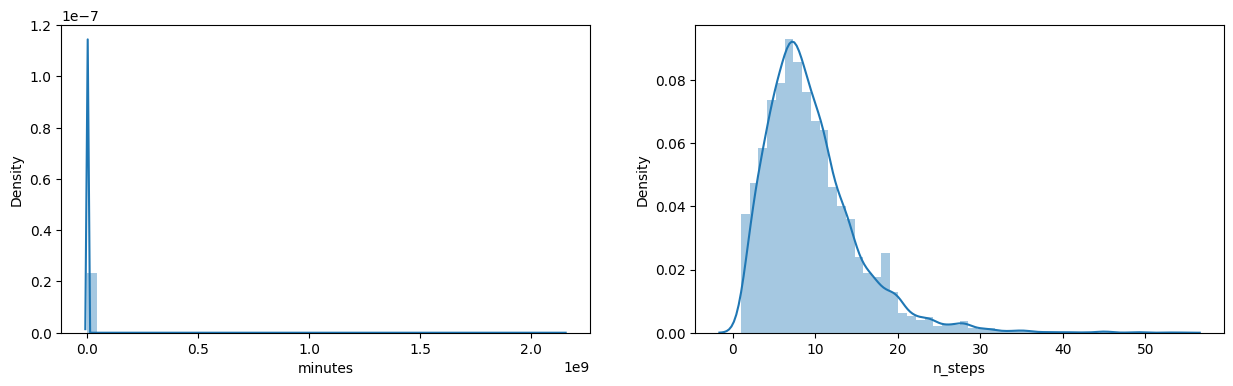

In [12]:
fig,ax = plt.subplots(1,2,figsize=(15,4))
sns.distplot(data["minutes"],ax=ax[0])
sns.distplot(data["n_steps"],ax=ax[1])

<AxesSubplot:>

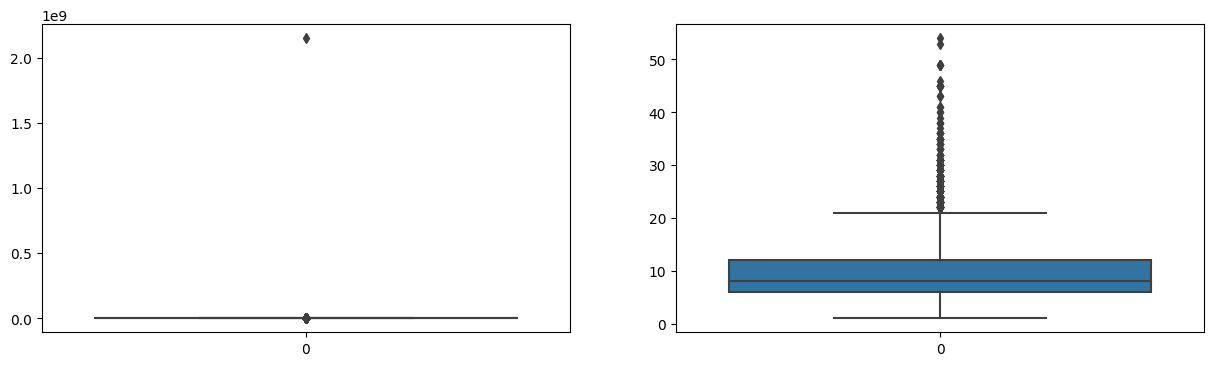

In [13]:
fig,ax = plt.subplots(1,2,figsize=(15,4))
sns.boxplot(data=data["minutes"],ax=ax[0])
sns.boxplot(data=data["n_steps"],ax=ax[1])

In [14]:
q1 = np.percentile(data["minutes"],25)
q3 = np.percentile(data["minutes"],75)
IQR = q3- q1
upper = q3 + 1.5*IQR
lower = q1 - 1.5*IQR

data = data.drop((data[data["minutes"]>=upper].index | data[data["minutes"]<=lower].index),axis=0)

In [15]:
q1 = np.percentile(data["n_steps"],25)
q3 = np.percentile(data["n_steps"],75)
IQR = q3- q1
upper = q3 + 1.5*IQR
lower = q1 - 1.5*IQR

data = data.drop((data[data["n_steps"]>=upper].index | data[data["n_steps"]<=lower].index),axis=0)

<AxesSubplot:>

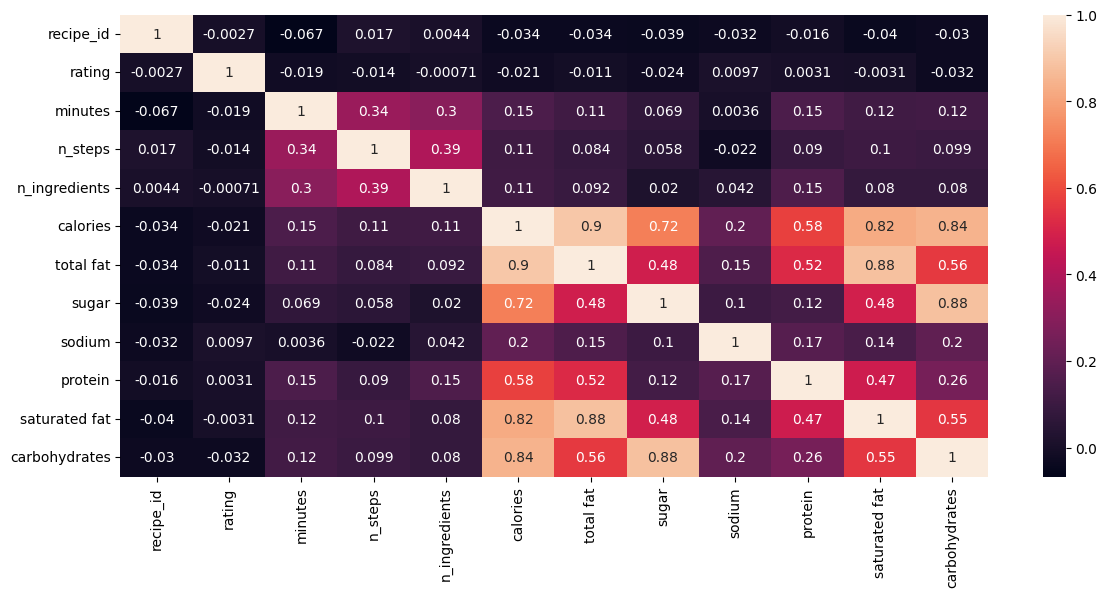

In [16]:
plt.figure(figsize=(14,6))
sns.heatmap(data.corr(),annot=True)

<AxesSubplot:xlabel='n_ingredients', ylabel='minutes'>

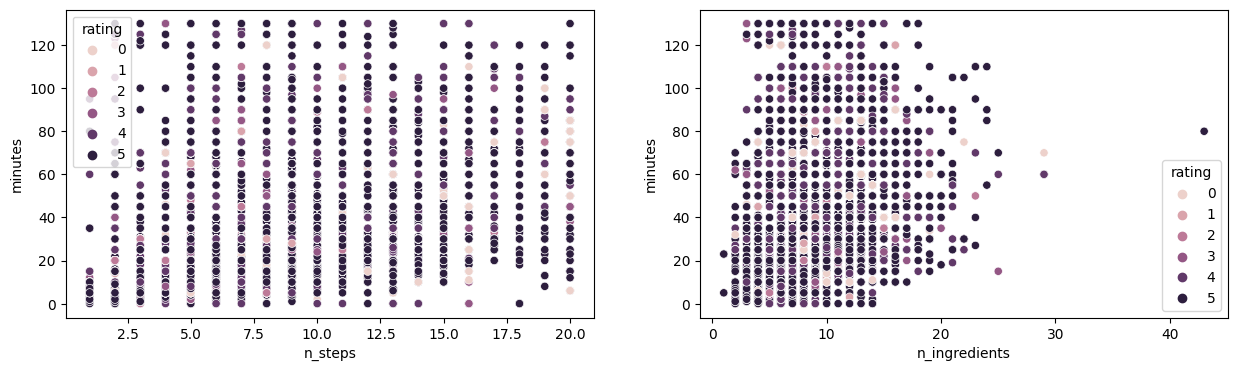

In [17]:
fig,ax = plt.subplots(1,2,figsize=(15,4))
sns.scatterplot(data=data,x="n_steps",y="minutes" ,hue="rating",ax=ax[0])
sns.scatterplot(data=data,x="n_ingredients",y="minutes" ,hue="rating",ax=ax[1])

<AxesSubplot:xlabel='carbohydrates', ylabel='sugar'>

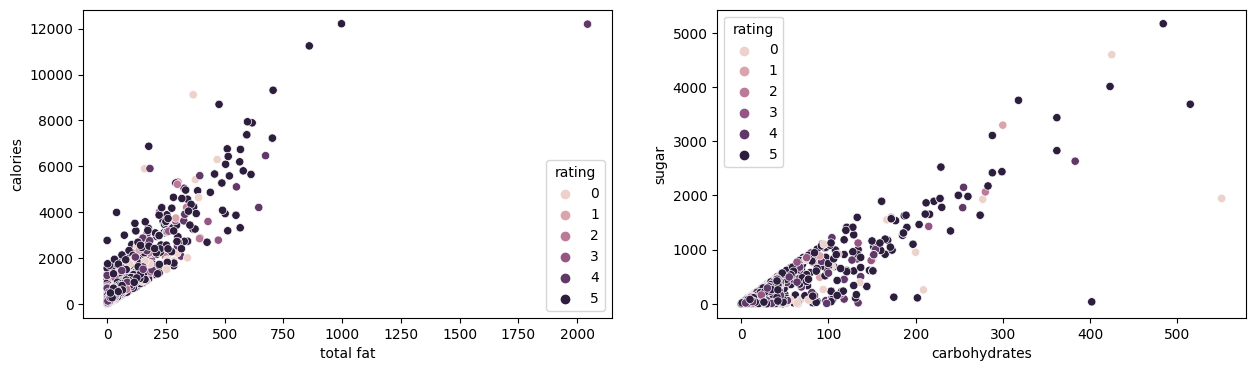

In [18]:
fig,ax = plt.subplots(1,2,figsize=(15,4))
sns.scatterplot(data=data,x="total fat",y="calories" ,hue="rating",ax=ax[0])
sns.scatterplot(data=data,x="carbohydrates",y="sugar" ,hue="rating",ax=ax[1])

<AxesSubplot:xlabel='n_steps', ylabel='n_ingredients'>

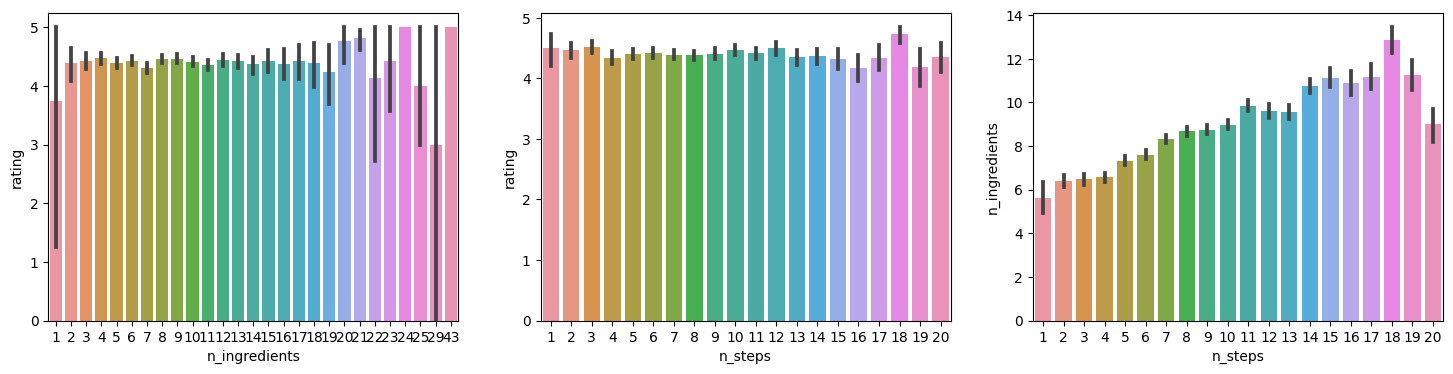

In [19]:
fig,ax = plt.subplots(1,3,figsize=(18,4))
sns.barplot(data=data,y="rating",x="n_ingredients",ax=ax[0])
sns.barplot(data=data,y="rating",x="n_steps",ax=ax[1])
sns.barplot(data=data,y="n_ingredients",x="n_steps",ax=ax[2])

In [20]:
data.isnull().sum()
data.dropna(inplace=True)

In [21]:
nonveg_ingred = ["egg","egg whites",]
def ingredient_check(data):
    veg = 0 
    for a in literal_eval(data):
        if a in nonveg_ingred:
            veg = 1
        else:
            veg = 0
    return veg
data["non veg"] = data["ingredients"].apply(ingredient_check)

In [22]:
data.columns

Index(['recipe_id', 'date', 'rating', 'review', 'name', 'minutes', 'tags',
       'nutrition', 'n_steps', 'steps', 'description', 'ingredients',
       'n_ingredients', 'calories', 'total fat', 'sugar', 'sodium', 'protein',
       'saturated fat', 'carbohydrates', 'non veg'],
      dtype='object')

In [23]:
data["non veg"].value_counts()

0    9277
1      55
Name: non veg, dtype: int64

In [24]:
rec = data[["recipe_id","rating","name","tags","description","ingredients",]]

In [27]:
rate = rec.groupby("name")["rating"].sum().reset_index()
rate

,name,rating
0,1 hour ham and bean soup,24
1,10 bars,4
2,10 minute mustard dip,10
3,10 minute szechuan chicken,5
4,10 minute tomato sauce from america s test kit...,9
...,...,...
6352,zucchini they will eat,5
6353,zucchini with mint and parsley,5
6354,zuppa di pesce cioppino or fish stew,9
6355,zwiebelfleisch onion beef,3


In [2]:
import nltk

In [28]:
rec.duplicated().sum()
rec.drop_duplicates(inplace=True)

In [29]:
rec.reset_index(drop=True,inplace=True)

In [30]:
rec.head(2)

,recipe_id,rating,name,tags,description,ingredients
0,30555,4,peach salsa,"['60-minutes-or-less', 'time-to-make', 'course...",an excellent salsa that goes well with fish di...,"['peaches', 'fresh tomatoes', 'red onions', 'j..."
1,99476,5,the best easy beef and broccoli stir fry,"['lactose', '30-minutes-or-less', 'time-to-mak...",i clipped this recipe from taste of home magaz...,"['cornstarch', 'water', 'garlic powder', 'bone..."


In [31]:
import string

def convert_to_list(data):
    a = data.replace("-","").replace("[","").replace("]","")
#     a = ''.join([i for i in a if not i.isdigit()])
    a = a.translate(str.maketrans('', '', string.punctuation))
    return a

In [32]:
rec["tags"] = rec["tags"].apply(lambda x: convert_to_list(x))
rec["ingredients"] = rec["ingredients"].apply(lambda x: convert_to_list(x))
rec["description"] = rec["description"].apply(lambda x: convert_to_list(x))

In [33]:
rec["rec"] = rec["tags"] + rec["description"] + rec["ingredients"]
rec = rec[~rec.duplicated("name")]
rec.reset_index(drop=True,inplace=True)

In [34]:
rec.to_csv("food.csv")

In [45]:
cv = TfidfVectorizer()
rec_tfidf = cv.fit_transform(rec["rec"])
name_tfidf = cv.fit_transform(rec["name"])
tags_tfidf = cv.fit_transform(rec["tags"])
rec_consin_sim = linear_kernel(rec_tfidf,rec_tfidf)
name_consin_sim = linear_kernel(name_tfidf,name_tfidf)
tags_consin_sim = linear_kernel(tags_tfidf,tags_tfidf)



In [46]:
indices = pd.Series(rec.index,index=rec['name'])
def recommendation(data,sim):
    re_li = []
    df = pd.DataFrame([])
    ind = indices[data]
#     ind = rec[rec["name"]==data].index[0]
    sim_score = list(enumerate(sim[ind]))
    sim_score = sorted(sim_score,key=lambda x:x[1],reverse=True)
    sim_score = sim_score[0:10]
    rec_indices = [i[0] for i in sim_score]
    for i in rec_indices:
        re_li.append(rec.iloc[i]["name"])
        
    return re_li


In [53]:
rec

,recipe_id,rating,name,tags,description,ingredients,rec
0,30555,4,peach salsa,60minutesorless timetomake course mainingredie...,an excellent salsa that goes well with fish di...,peaches fresh tomatoes red onions jalapeno pep...,60minutesorless timetomake course mainingredie...
1,99476,5,the best easy beef and broccoli stir fry,lactose 30minutesorless timetomake course main...,i clipped this recipe from taste of home magaz...,cornstarch water garlic powder boneless round ...,lactose 30minutesorless timetomake course main...
2,424475,4,bell pepper egg in a hole,15minutesorless timetomake course preparation ...,nice decorative way to serve egg for breakfast...,olive oil bell pepper eggs coarse salt ground ...,15minutesorless timetomake course preparation ...
3,261471,5,black bean and pineapple quesadilla,30minutesorless timetomake course mainingredie...,i recreated this dish from a favorite at a loc...,flour tortilla green chili onion pineapple tid...,30minutesorless timetomake course mainingredie...
4,10744,4,delicious chicken pot pie,weeknight timetomake course mainingredient cui...,this chicken pot pie recipe takes a little tim...,potato onion celery carrot margarine allpurpos...,weeknight timetomake course mainingredient cui...
...,...,...,...,...,...,...,...
6352,209215,5,couscous with spinach and pine nuts,60minutesorless timetomake course mainingredie...,our version of comfort food if you prefer str...,couscous boiling water salt olive oil garlic c...,60minutesorless timetomake course mainingredie...
6353,184262,4,caramelised onion bacon camembert tart,bacon 60minutesorless timetomake course mainin...,this is ideal for a light lunch or snack serve...,phyllo pastry butter onions brown sugar balsam...,bacon 60minutesorless timetomake course mainin...
6354,257066,4,sweet potato scones the best diabetic change...,30minutesorless timetomake course mainingredie...,try these warm with coffee or tea they are lov...,allpurpose flour brown sugar baking powder pum...,30minutesorless timetomake course mainingredie...
6355,66037,5,fabulous banana cream pie,30minutesorless timetomake course mainingredie...,this is such a great recipe we have people in ...,sugarfree vanilla pudding mix skim milk banana...,30minutesorless timetomake course mainingredie...


In [47]:
# Recommendation based on name

recommendation(rec[:1]["name"][0],name_consin_sim)

['peach salsa',
 'ww fresh peach salsa',
 'peach waffles',
 'peach dessert',
 'peach crisp',
 'italian peach salad',
 'chili s salsa',
 'strawberry salsa',
 'easy peach crisp',
 'salsa cakes']

In [52]:
# Recommendation based on tags, description, ingredients

recommendation(rec[:1]["tags"][0],rec_consin_sim)

KeyError: 1